Firstly all the necessary imports

In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model
from keras import backend as K
from keras.layers import Activation
import tensorflow as tf
import keras.layers as l
import keras.models as m
import tensorflow     
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from keras.layers.merge import concatenate
from keras.models import load_model
from numpy import argmax
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.layers.merge import concatenate
import random 
import ssl
import keras
import pickle
from tqdm import tqdm
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input

A)

Our first goal is to create a robust model that is good at predicting mnist dataset

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


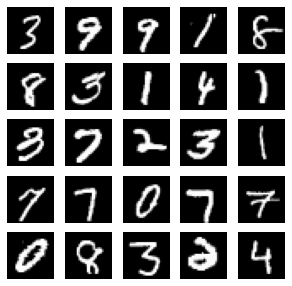

In [28]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

Now we will create a model that fulfills our expectations. We will mostly use lecun function as activation function of the inner layers as well as  ensembling technique

In [25]:
#Firstly we create a function that only returns the function itself (lecun). We will use as the activation function of
#our models

def Lecun_(x):
    tan_h=K.tanh(x) #hyperbolic tan function
    t=1.7159*(tan_h)+0.01*x #lecun function
    return t


Firstly we will create the models that will contribute to the assembling of our ensemble models

In [4]:
# fit model on dataset
def fit_model(trainX, trainy,testX,testy):
    #get_custom_objects().update({'lecun':Lecun_})
    # define model
    Input = l.Input(shape=(28, 28, 1))
    hidden = l.Conv2D(32, (3,3), padding='same',activation=Lecun_)(Input)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Conv2D(64, (3,3), padding='same',activation=Lecun_)(hidden)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Conv2D(128, (3,3), padding='same',activation=Lecun_)(hidden)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Flatten()(hidden)
    output = l.Dense(10, activation='softmax')(hidden)
    model = m.Model(Input, output)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adam(),    
    metrics=["accuracy"]
)

    # fit model
    model.fit(
    trainX,
    trainy,
    batch_size=128,
    epochs=3,
    validation_data=(testX,testy))
    return model

n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(x_train, y_train,x_test,y_test)
    # save model
    filename = 'models_new/model_' + str(i + 1) 
    model.save(filename)
    print('>Saved %s' % filename)

Epoch 1/3
469/469 [==============================] - 174s 366ms/step - loss: 0.2184 - accuracy: 0.9400 - val_loss: 0.0517 - val_accuracy: 0.9833
Epoch 2/3
469/469 [==============================] - 217s 462ms/step - loss: 0.0506 - accuracy: 0.9849 - val_loss: 0.0383 - val_accuracy: 0.9872
Epoch 3/3
469/469 [==============================] - 211s 450ms/step - loss: 0.0323 - accuracy: 0.9899 - val_loss: 0.0337 - val_accuracy: 0.9891
INFO:tensorflow:Assets written to: models_new/model_1\assets
>Saved models_new/model_1
Epoch 1/3
469/469 [==============================] - 206s 435ms/step - loss: 0.2209 - accuracy: 0.9394 - val_loss: 0.0538 - val_accuracy: 0.9827
Epoch 2/3
469/469 [==============================] - 241s 513ms/step - loss: 0.0500 - accuracy: 0.9848 - val_loss: 0.0367 - val_accuracy: 0.9886
Epoch 3/3
469/469 [==============================] - 199s 424ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.0267 - val_accuracy: 0.9908
INFO:tensorflow:Assets written to: models_n

Now let's load all the models and add them to a list called members

In [3]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models_new/model_' + str(i + 1) 
        # load model from file
        model = load_model(filename)#,custom_objects={'lecun':Lecun_}
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# load all models
n_members = 5
members = load_all_models(n_members)

>loaded models_new/model_1
>loaded models_new/model_2
>loaded models_new/model_3
>loaded models_new/model_4
>loaded models_new/model_5


We will create two types of ensemble models and we will pick the one with the best results (best accuracy in the prediction of y_test)

First type of ensemble (Seperate Stacking Model)

In [4]:
# stacked generalization with neural net meta model on mnist dataset

# Some necessary functions for Seperate Stacking


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    inputy=np.argmax(inputy,axis=1)
    model.fit(stackedX, inputy)
    return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat



In [7]:
model = fit_stacked_model(members, x_train, y_train)
# evaluate model on test set
yhat = stacked_prediction(members, model, x_test)
yhat = to_categorical(yhat,10)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.4f' % acc)


Stacked Test Accuracy: 0.9923


We managed to create a Seperate Stacking Model that achieved 99.23 % accuracy in predicting y_test. Mind that all accuracies of the 5 seperate models that contributed in the creation of the Seperate Stacking Model were under 99,08 %

In [8]:
#Let's save the model for possible further exploitation in the exercise 


filename = 'ex_2_final_model/final_model_seperate_stacking.sav' 
pickle.dump(model, open(filename, 'wb'))



Let's proceed to the second type of ensemble (Integrated Stacking Model)

In [10]:

# Some necessary functions for Integrated Stacking

 
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(32, activation=Lecun_)(merge)
    output = Dense(10, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    #plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    #inputy_enc = to_categorical(inputy)
    inputy_enc=inputy
    # fit model
    model.fit(X, inputy_enc, epochs=4, verbose=1)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

In [13]:
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
tf.config.run_functions_eagerly(True)
fit_stacked_model(stacked_model, x_train, y_train)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, x_test)
yhat = to_categorical(argmax(yhat, axis=1))
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.4f' % acc)

C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/4
1875/1875 [==============================] - 1246s 663ms/step - loss: 0.0691 - accuracy: 0.9872
Epoch 2/4
1875/1875 [==============================] - 1113s 594ms/step - loss: 0.0136 - accuracy: 0.9970
Epoch 3/4
1875/1875 [==============================] - 1065s 568ms/step - loss: 0.0132 - accuracy: 0.9969
Epoch 4/4
1875/1875 [==============================] - 1078s 575ms/step - loss: 0.0129 - accuracy: 0.9972
Stacked Test Accuracy: 0.9920


We managed to create an Integrated Stacking Model that achieved 99.20 % accuracy in predicting y_test. Mind that all accuracies of the 5 seperate models that contributed in the creation of the Integrated Stacking Model were under 99,08 %

In [14]:
#Let's save the model for possible further exploitation in the exercise 
filename = 'ex_2_final_model/final_model_integrated_stacking' 
stacked_model.save(filename)
print('>Saved %s' % filename)

INFO:tensorflow:Assets written to: ex_2_final_model/final_model_integrated_stacking\assets


>Saved ex_2_final_model/final_model_integrated_stacking


Now we are going to load the models again.






In [7]:
# load the separated model from disk

loaded_model_1 = pickle.load(open('ex_2_final_model/final_model_seperate_stacking.sav' , 'rb'))
# load all 5 seperate keras models
n_members = 5
members = load_all_models(n_members)
yhat = stacked_prediction(members, loaded_model_1, x_test)
yhat = to_categorical(yhat,10)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.4f' % acc)

>loaded models_new/model_1
>loaded models_new/model_2
>loaded models_new/model_3
>loaded models_new/model_4
>loaded models_new/model_5
Stacked Test Accuracy: 0.9923


In [11]:
# load the integrated model from disk
loaded_model_2 = load_model('ex_2_final_model/final_model_integrated_stacking' )
yhat = predict_stacked_model(loaded_model_2, x_test)
yhat = to_categorical(argmax(yhat, axis=1))
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.4f' % acc)



Stacked Test Accuracy: 0.9920


B)

So in the above question A) we managed to create 2 robust models that achieve accuracy of the validation dataset 99,23 % and 99,20 % respectively. But now, in order to demonstrate adversarial examples, we will use one of the five models that contributed to the assembling of our two ensemble models. Mind that those individual models achieved a great accuracy percentage as well ( all of them achieved accuracy between 98,6 % and 99,08 %)

In [29]:
# We randomly select the second out of the five models
classifier=load_model('models_new/model_2')


We will create a MNIST - simple generator f(w) =x, exploiting our classifier in order to proceed to an evasion attack against it. This will be done by creating adversarial examples through the following GAN that we will construct. We will also plot the two networks (the acversial and the composite of the adversial), in order to demonstrate the flow of the layers

In [30]:


# So this function takes as input one digit (integer), in order to rename the layers of the GAN model created each time, so that 
# we avoid the unique layer name' issue. Also, each time a new GAN will be created , so the models that compose the GAN, will 
# be deleted every time the function is called, if they have been created again before (in that case, erase_ old _models should be
# 'yes as an input'

def GAN(digit,erase_old_models):
    global advModel
    global wholeModel
    if erase_old_models=='yes':
        del advModel
        del wholeModel
     
    classifier.trainable = False


    Input = l.Input(shape=(1,),name='Input_'+str(digit))
    hidden = l.Dense(256, activation='relu',name='hidden_1_'+str(digit))(Input)
    hidden = l.Dense(28*28, activation="sigmoid",name='hidden_2_'+str(digit))(hidden)
    output = l.Reshape((28, 28),name='output_'+ str(digit))(hidden)

    advModel = m.Model(Input, output)
    advModel.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

    )




    wholeModel = m.Model(Input, classifier(output))
    wholeModel.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.009),
    metrics=["accuracy"]
    )
    
    

Let's take a first glimpse of how our GAN looks. We will initiate firstly the GAN function

In [31]:
GAN(0,'no')
advModel.summary() #our generator model
wholeModel.summary() # the whole GAN model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_0 (InputLayer)        [(None, 1)]               0         
                                                                 
 hidden_1_0 (Dense)          (None, 256)               512       
                                                                 
 hidden_2_0 (Dense)          (None, 784)               201488    
                                                                 
 output_0 (Reshape)          (None, 28, 28)            0         
                                                                 
Total params: 202,000
Trainable params: 202,000
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_0 (InputLayer)        [(None,

Now let's plot thw flow of these models

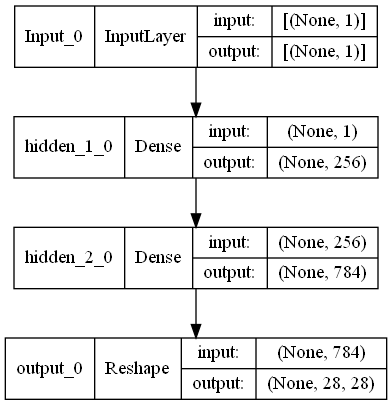

In [20]:
tf.keras.utils.plot_model(advModel, show_shapes=True)

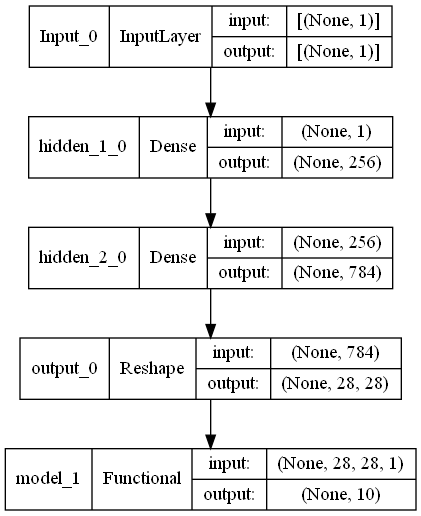

In [21]:
tf.keras.utils.plot_model(wholeModel, show_shapes=True,)

For the whole x_test dataset, we will create a list called predictions to save the predictions of our classifier. For example, if predictions[250]=5, it means that x_test[250] will be predicted as 5 from the classifier

In [32]:
predictions=[]
for num in range (len(x_test)):
    predictions.append(np.argmax(classifier.predict(x_test[num].reshape((1,28,28)))))

In [33]:
# So we will create five lists, for each chosen digit. For example predict_2 will be filled with 5 samples of x_test that 
#were inserted as input in classifier and predicted as output number 2

for num in range (0,9,2):
    #initilization of the 5 lists 
    globals()['predict_%s' %num]=[]


def sampling_pred(z,k):
    # a simple function that recieves as input a list (z) that contains random samples of x_test and a sample of x_test(k)
    #and if the list has less than 5 instances in it, it adds k in the list
    if len(z)==5:
        pass
    else:
        z.append(k)
    return z

for num in range(0,len(x_test),3):
    if predictions[num]==0:
        predict_0=sampling_pred(predict_0,x_test[num])
    elif predictions[num]==2:
        predict_2=sampling_pred(predict_2,x_test[num])
    elif predictions[num]==4:
        predict_4=sampling_pred(predict_4,x_test[num])
    elif predictions[num]==6:
        predict_6=sampling_pred(predict_6,x_test[num])
    elif predictions[num]==8:
        predict_8=sampling_pred(predict_8,x_test[num])

Let's start creating the adversial examples. We will choose as digits i the even numbers (0,2,4,6,8) and we will misclassify them as odd Js (1,3,5,7,9) respectively, using one hot encoding. In order to do so, we will find ten predictions of our x_test dataset for each of the even numbers, in order to perform training. Firstly, for each training, we will show just one example to our Generator model and we will see how that will go. On the same time,  we will produce 5 images. For example, advImage_4, will be an array produced a 4 which will deceit our model in order to produce as a result something that possibly will confuse our model to produce 5 as its prediction

In [34]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=0
#GAN(check,'no') We have called the function in the above cells with the same inputs, so no need to call it again
for _ in tqdm(range(1000)):
    advModel.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    
    

100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


In [35]:
#Then we misclassify 2s as 3s (one hot encoding of three: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] )
check=2
GAN(check,'yes')
for _ in tqdm(range(1000)):
    advModel.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel.predict([np.array([check+1])]).reshape(1, 28, 28, 1)

100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s]


In [36]:
#Then we misclassify 4s as 5s (one hot encoding of five: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] )
check=4
GAN(check,'yes')
for _ in tqdm(range(1000)):
    advModel.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel.predict([np.array([check+1])]).reshape(1, 28, 28, 1)

100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


In [37]:
#Then we misclassify 6s as 7s (one hot encoding of seven: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] )
check=6
GAN(check,'yes')
for _ in tqdm(range(1000)):
    advModel.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel.predict([np.array([check+1])]).reshape(1, 28, 28, 1)

100%|██████████| 1000/1000 [00:48<00:00, 20.83it/s]


In [38]:
#Finally we misclassify 8s as 9s (one hot encoding of nine: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] )
check=8
GAN(check,'yes')
for _ in tqdm(range(1000)):
    advModel.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel.predict([np.array([check+1])]).reshape(1, 28, 28, 1)

100%|██████████| 1000/1000 [00:50<00:00, 19.93it/s]


Now let's create the predict function for  our classifier. Its input will be the advImage (input as x - an adverse image to mnist dataset), an integer (input as dec_int) which will be the integer from which advImage is originated, another integer (no_of_originals) which indicates from how many original pictures our adversarial example was created and  the model (input as predictor) which will be used to predict the outcome (in our case predictor=classifier).  For example, advImage_4 will be accompanied by dec_int=4, because it represents an original image of 4 that was manipulated to produce an adverserial example, and no_of_originals=1 because only one original image contributed to the creation of the adversarial image

In [39]:
def predict(x, predictor,dec_int,no_of_originals):
    yhat = predictor.predict(x)
    prediction = np.argmax(yhat)
    # Print the prediction of the network
    print('Network output: ')
    print(yhat)
    print('Network prediction: ')
    print(prediction)
    plt.bar(range(10), yhat[0])
    plt.show()
    # Draw the images
    print('Adverserial image: ')
    plt.imshow(x.reshape((28,28)), cmap='Greys') 
    plt.show()
    print('Actual image(s) from which the adverserial image was produced: ')
    for length in range(no_of_originals):
        plt.imshow(globals()['predict_%s' %dec_int][length], cmap='Greys')
        plt.show()

The adverserial result for 0 (wrong prediction - it confused it as a 1)

Network output: 
[[9.7487964e-02 7.9289776e-01 6.9227419e-03 1.3436265e-03 7.6077379e-02
  8.2043745e-03 5.4493528e-03 9.0027843e-03 4.6081154e-04 2.1531160e-03]]
Network prediction: 
1


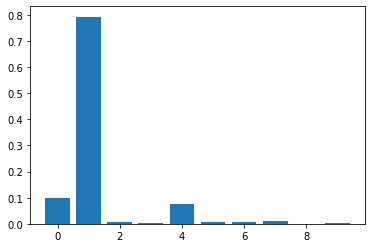

Adverserial image: 


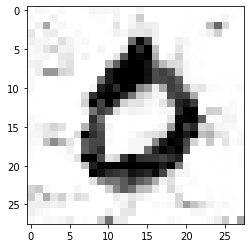

Actual image(s) from which the adverserial image was produced: 


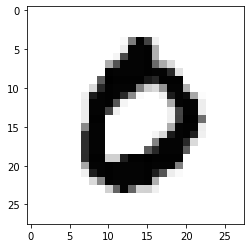

In [40]:
predict(advImage_0, classifier,0,1)

The adverserial result for 2 (wrong prediction - it confused it as a 3)

Network output: 
[[2.4416143e-04 1.3625719e-04 2.3239857e-02 9.4778222e-01 5.8364381e-05
  1.0097973e-02 1.9523525e-06 9.8693091e-04 1.4720824e-02 2.7314471e-03]]
Network prediction: 
3


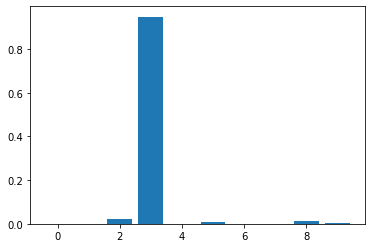

Adverserial image: 


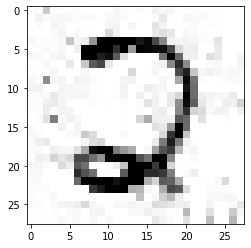

Actual image(s) from which the adverserial image was produced: 


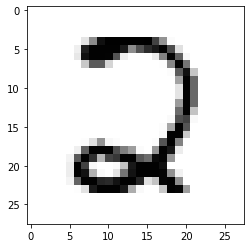

In [41]:
predict(advImage_2, classifier,2,1)

The adverserial result for 4 (wrong prediction - it confused it as a 5)

Network output: 
[[5.9238309e-06 2.4718765e-05 4.0302511e-06 7.9612173e-03 2.6809380e-03
  8.8221282e-01 4.6146702e-04 2.7168688e-05 9.7042158e-02 9.5795579e-03]]
Network prediction: 
5


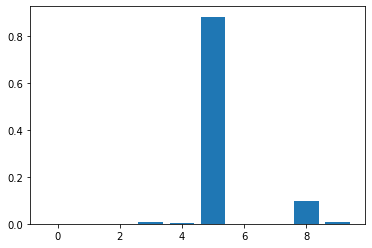

Adverserial image: 


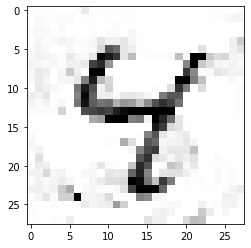

Actual image(s) from which the adverserial image was produced: 


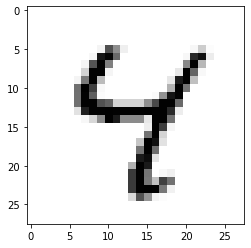

In [42]:
predict(advImage_4, classifier,4,1)

The adverserial result for 6 (wrong prediction - it confused it as a 7)

Network output: 
[[3.6315253e-04 7.1752543e-04 1.9558035e-02 6.9558084e-02 1.9332495e-01
  2.1136402e-01 2.2764171e-02 4.6752051e-01 9.8200468e-03 5.0095310e-03]]
Network prediction: 
7


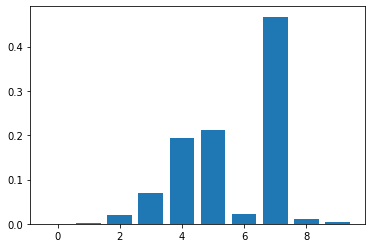

Adverserial image: 


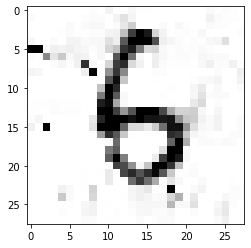

Actual image(s) from which the adverserial image was produced: 


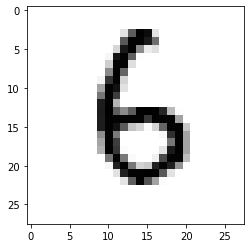

In [43]:
predict(advImage_6, classifier,6,1)

The adverserial result for 8 (wrong prediction - it confuset it as 3)

Network output: 
[[1.0732845e-03 1.6270751e-06 4.2752101e-04 2.1314952e-01 2.3732329e-04
  7.9211533e-02 5.8448792e-04 3.4151124e-06 2.4734208e-01 4.5796925e-01]]
Network prediction: 
9


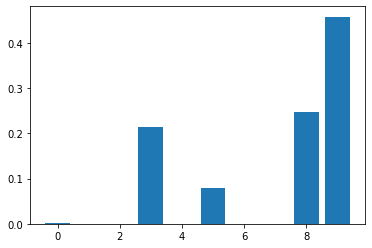

Adverserial image: 


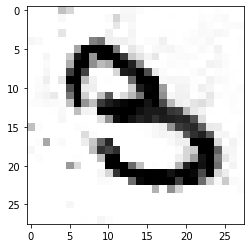

Actual image(s) from which the adverserial image was produced: 


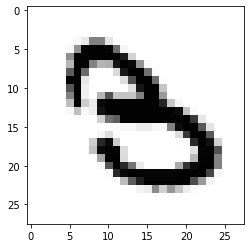

In [44]:
predict(advImage_8, classifier,8,1)

C)

In [47]:
ssl._create_default_https_context = ssl._create_unverified_context
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [48]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [49]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [40]:

def fit_model_cifar(trainX, trainy,testX,testy):
    #get_custom_objects().update({'lecun':Lecun_})
    # define model
    Input = l.Input(shape=(32, 32, 3))
    hidden = l.Conv2D(32, (3,3), padding='same',activation=Lecun_)(Input)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Conv2D(64, (3,3), padding='same',activation=Lecun_)(hidden)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Conv2D(128, (3,3), padding='same',activation=Lecun_)(hidden)
    hidden = l.MaxPooling2D((3,3))(hidden)
    hidden = l.Flatten()(hidden)
    output = l.Dense(10, activation='softmax')(hidden)
    model = m.Model(Input, output)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adam(),    
    metrics=["accuracy"]
)

    # fit model
    model.fit(
    trainX,
    trainy,
    batch_size=128,
    epochs=5,
    validation_data=(testX,testy))
    return model


n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model_cifar(x_train, y_train,x_test,y_test)
    # save model
    filename = 'models_new_cifar/model_' + str(i + 1) 
    model.save(filename)
    print('>Saved %s' % filename)

Epoch 1/5
391/391 [==============================] - 249s 637ms/step - loss: 1.4448 - accuracy: 0.4863 - val_loss: 1.1759 - val_accuracy: 0.5888
Epoch 2/5
391/391 [==============================] - 252s 645ms/step - loss: 1.0770 - accuracy: 0.6213 - val_loss: 1.0347 - val_accuracy: 0.6353
Epoch 3/5
391/391 [==============================] - 253s 647ms/step - loss: 0.9279 - accuracy: 0.6770 - val_loss: 0.9546 - val_accuracy: 0.6677
Epoch 4/5
391/391 [==============================] - 260s 665ms/step - loss: 0.8224 - accuracy: 0.7157 - val_loss: 0.9214 - val_accuracy: 0.6802
Epoch 5/5
391/391 [==============================] - 252s 645ms/step - loss: 0.7431 - accuracy: 0.7426 - val_loss: 0.9217 - val_accuracy: 0.6776
INFO:tensorflow:Assets written to: models_new_cifar/model_1\assets


INFO:tensorflow:Assets written to: models_new_cifar/model_1\assets


>Saved models_new_cifar/model_1


C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
391/391 [==============================] - 250s 640ms/step - loss: 1.4569 - accuracy: 0.4826 - val_loss: 1.1669 - val_accuracy: 0.5859
Epoch 2/5
391/391 [==============================] - 251s 643ms/step - loss: 1.0826 - accuracy: 0.6221 - val_loss: 1.0149 - val_accuracy: 0.6409
Epoch 3/5
391/391 [==============================] - 250s 640ms/step - loss: 0.9278 - accuracy: 0.6767 - val_loss: 0.9489 - val_accuracy: 0.6726
Epoch 4/5
391/391 [==============================] - 252s 645ms/step - loss: 0.8198 - accuracy: 0.7149 - val_loss: 0.8972 - val_accuracy: 0.6913
Epoch 5/5
391/391 [==============================] - 262s 669ms/step - loss: 0.7396 - accuracy: 0.7447 - val_loss: 0.8995 - val_accuracy: 0.6887
INFO:tensorflow:Assets written to: models_new_cifar/model_2\assets


INFO:tensorflow:Assets written to: models_new_cifar/model_2\assets


>Saved models_new_cifar/model_2


C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
391/391 [==============================] - 289s 738ms/step - loss: 1.4821 - accuracy: 0.4724 - val_loss: 1.2398 - val_accuracy: 0.5596
Epoch 2/5
391/391 [==============================] - 256s 654ms/step - loss: 1.1170 - accuracy: 0.6092 - val_loss: 1.0717 - val_accuracy: 0.6139
Epoch 3/5
391/391 [==============================] - 252s 644ms/step - loss: 0.9653 - accuracy: 0.6644 - val_loss: 0.9758 - val_accuracy: 0.6562
Epoch 4/5
391/391 [==============================] - 257s 658ms/step - loss: 0.8599 - accuracy: 0.7035 - val_loss: 0.9324 - val_accuracy: 0.6720
Epoch 5/5
391/391 [==============================] - 255s 651ms/step - loss: 0.7727 - accuracy: 0.7335 - val_loss: 0.8966 - val_accuracy: 0.6864
INFO:tensorflow:Assets written to: models_new_cifar/model_3\assets


INFO:tensorflow:Assets written to: models_new_cifar/model_3\assets


>Saved models_new_cifar/model_3


C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
391/391 [==============================] - 252s 645ms/step - loss: 1.4891 - accuracy: 0.4673 - val_loss: 1.2094 - val_accuracy: 0.5725
Epoch 2/5
391/391 [==============================] - 257s 657ms/step - loss: 1.1194 - accuracy: 0.6055 - val_loss: 1.0378 - val_accuracy: 0.6398
Epoch 3/5
391/391 [==============================] - 254s 650ms/step - loss: 0.9607 - accuracy: 0.6653 - val_loss: 0.9980 - val_accuracy: 0.6509
Epoch 4/5
391/391 [==============================] - 252s 644ms/step - loss: 0.8524 - accuracy: 0.7041 - val_loss: 0.9175 - val_accuracy: 0.6801
Epoch 5/5
391/391 [==============================] - 252s 645ms/step - loss: 0.7727 - accuracy: 0.7325 - val_loss: 0.8785 - val_accuracy: 0.6992
INFO:tensorflow:Assets written to: models_new_cifar/model_4\assets


INFO:tensorflow:Assets written to: models_new_cifar/model_4\assets


>Saved models_new_cifar/model_4


C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
391/391 [==============================] - 252s 643ms/step - loss: 1.4808 - accuracy: 0.4721 - val_loss: 1.1900 - val_accuracy: 0.5822
Epoch 2/5
391/391 [==============================] - 259s 662ms/step - loss: 1.0888 - accuracy: 0.6187 - val_loss: 1.0204 - val_accuracy: 0.6378
Epoch 3/5
391/391 [==============================] - 270s 690ms/step - loss: 0.9264 - accuracy: 0.6792 - val_loss: 0.9169 - val_accuracy: 0.6761
Epoch 4/5
391/391 [==============================] - 367s 940ms/step - loss: 0.8265 - accuracy: 0.7147 - val_loss: 0.8832 - val_accuracy: 0.6955
Epoch 5/5
391/391 [==============================] - 334s 853ms/step - loss: 0.7354 - accuracy: 0.7470 - val_loss: 0.8638 - val_accuracy: 0.7015
INFO:tensorflow:Assets written to: models_new_cifar/model_5\assets


INFO:tensorflow:Assets written to: models_new_cifar/model_5\assets


>Saved models_new_cifar/model_5


In [12]:
#As we dit for the MNIST dataset, we will create a function that will load all the saved models of the CIFAR10 Dataset
def load_all_models_2(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models_new_cifar/model_' + str(i + 1) 
        # load model from file
        model = load_model(filename)#,custom_objects={'lecun':Lecun_}
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# load all models
n_members = 5

#Now we will save these 5 models produced above as members_2. 
members_2 = load_all_models_2(n_members)

>loaded models_new_cifar/model_1
>loaded models_new_cifar/model_2
>loaded models_new_cifar/model_3
>loaded models_new_cifar/model_4
>loaded models_new_cifar/model_5


Now, in order to demonstrate adversarial examples, we will use one of the five models that we saved. Those individual models achieved a fair accuracy percentage as well ( all of them achieved accuracy between 68 % and 71 %)

In [13]:
# We randomly select the second out of the five models
classifier_2=load_model('models_new_cifar/model_2')

We will create a CIFAR10 - simple generator f(w) =x, exploiting our classifier_2 in order to proceed to an evasion attack against it. This will be done by creating adversarial examples through the following GAN that we will construct. We will also plot the two networks (the acversial and the composite of the adversial), in order to demonstrate the flow of the layers

In [14]:

# So this function takes as input one digit (integer), in order to rename the layers of the GAN model created each time, so that 
# we avoid the unique layer name' issue. Also, each time a new GAN will be created , so the models that compose the GAN, will 
# be deleted every time the function GAN_2 is called, if they have been created again before (in that case, erase_ old _models should be
# 'yes as an input'

def GAN_2(digit,erase_old_models):
    global advModel_2
    global wholeModel_2
    if erase_old_models=='yes':
        del advModel_2
        del wholeModel_2
     
    classifier_2.trainable = False


    _2_Input = l.Input(shape=(1,),name='2_Input_'+str(digit))
    _2_hidden = l.Dense(256, activation='relu',name='2_hidden_1_'+str(digit))(_2_Input)
    _2_hidden = l.Dense(32*32*3, activation="sigmoid",name='2_hidden_2_'+str(digit))(_2_hidden)
    _2_output = l.Reshape((32, 32,3),name='2_output_'+ str(digit))(_2_hidden)

    advModel_2 = m.Model(_2_Input, _2_output)
    advModel_2.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

    )




    wholeModel_2 = m.Model(_2_Input, classifier_2(_2_output))
    wholeModel_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.009),
    metrics=["accuracy"]
    )
    

Let's take a first glimpse of how our GAN looks. We will initiate firstly the GAN_2 function

In [15]:
GAN_2(0,'no')
advModel_2.summary() #our generator model
wholeModel_2.summary() # the whole GAN model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2_Input_0 (InputLayer)      [(None, 1)]               0         
                                                                 
 2_hidden_1_0 (Dense)        (None, 256)               512       
                                                                 
 2_hidden_2_0 (Dense)        (None, 3072)              789504    
                                                                 
 2_output_0 (Reshape)        (None, 32, 32, 3)         0         
                                                                 
Total params: 790,016
Trainable params: 790,016
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2_Input_0 (InputLayer)      [(None, 1

Now let's plot thw flow of these models

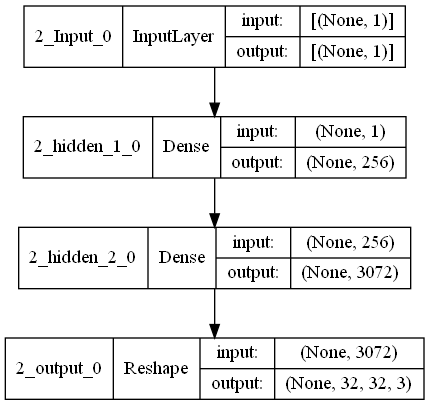

In [16]:
tf.keras.utils.plot_model(advModel_2, show_shapes=True)

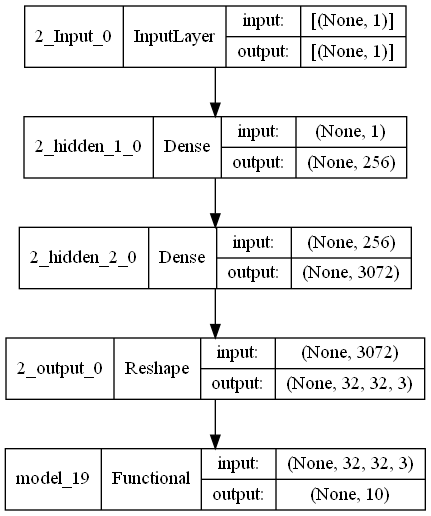

In [17]:
tf.keras.utils.plot_model(wholeModel_2, show_shapes=True,)

For the whole x_test dataset, we will create a list called predictions_2 to save the predictions of our classifier_2. For example, if predictions_2[250]=5, it means that x_test[250] will be predicted as 5 from the classifier_2

In [22]:
predictions_2=[]
for num in range (len(x_test)):
    predictions_2.append(np.argmax(classifier_2.predict(x_test[num].reshape(1,32,32,3))))

In [23]:
# So we will create ten lists, for each chosen digit. For example predict_9 will be filled with 5 samples of x_test that 
#were inserted as input in classifier and predicted as output number 9 (meaning that they were predicted as trucks for the
#case of the CIFAR 10 dataset)

for num in range (0,10):
    #initilization of the 10 lists 
    globals()['predict_%s' %num]=[]


def sampling_pred(z,k):
    # a simple function that recieves as input a list (z) that contains random samples of x_test and a sample of x_test(k)
    #and if the list has less than 5 instances in it, it adds k in the list
    if len(z)==5:
        pass
    else:
        z.append(k)
    return z

for num in range(0,len(x_test),2):
    label= predictions_2[num]
    globals()['predict_%s' %label]=sampling_pred(globals()['predict_%s' %label],x_test[num])
    

Let's start creating the adversial examples. We will now select a random sample  of the x_test of CIFAR10 dataset along with its prediciton (from predictions_2) and we will misclassify it to all other classes of the dataset

In [50]:
z=random.randint(0,10000) # or z=random.randint(0,250) an exoume meiwsei to megethos toy x_test gia pio grhgora
random_selection=x_test[z]
random_prediction=predictions_2[z]

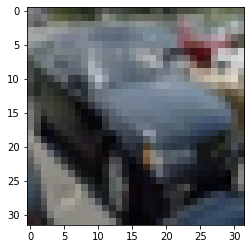

In [51]:
plt.imshow(random_selection)

In [52]:
random_prediction

1

So as shown above, we randomly picked an automobile, and our classifier_2 has correctly predicted it(1 is the prediction for automobiles in CIFAR10 Dataset). So we will create 9 adversarial examples of that image (for all other 9 classes of the CIFAR10). For example, advImage_4, will be an array produced of our automobile which will deceit our model in order to produce as a result something that possibly will confuse our model to produce 4 (deer for the case of the CIFAR 10 Dataset) as its prediction

In [53]:
#So we begin training. Firstly we misclassify 1 as 0 (one hot encoding of zero: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] )
check=0
#GAN_2(check,'no') We have called the function in the above cells with the same inputs, so no need to call it again
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:09<00:00, 14.37it/s]


In [54]:
#Then we misclassify 1 as 2 
check=2
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


In [55]:
#Then we misclassify 1 as 3 
check=3
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s]


In [56]:
#Then we misclassify 1 as 4
check=4
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]


In [57]:
#Then we misclassify 1 as 5
check=5
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:13<00:00, 13.54it/s]


In [58]:
#Then we misclassify 1 as 6
check=6
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


In [59]:
#Then we misclassify 1 as 7
check=7
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:32<00:00, 10.85it/s]


In [60]:
#Then we misclassify 1 as 8
check=8
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:26<00:00, 11.60it/s]


In [61]:
#Then we misclassify 1 as 9
check=9
GAN_2(check,'yes')
for _ in tqdm(range(1000)):
    advModel_2.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_2.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_2.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]


Now let's create the predict_2 function for  our classifier_2. Its input will be the advImage (input as x - an adverse image to CIFAR10 dataset) and  the model (input as predictor) which will be used to predict the outcome (in our case predictor=classifier_2). Inside the function we will use the random_selection array that we created in the above cells from which all the adversarial examples are originated

In [121]:
def predict_2(x, predictor):
    yhat = predictor.predict(x)
    prediction = np.argmax(yhat)
    # Print the prediction of the network
    print('Network output: ')
    print(yhat)
    print('Network prediction: ')
    print(prediction)
    plt.bar(range(10), yhat[0])
    plt.show()
    # Draw the images
    print('Adverserial image: ')
    plt.imshow(x.reshape((32,32,3)))
    plt.show()
    print('Actual image from which the adverserial image was produced: ')
    plt.imshow(random_selection)
    plt.show()

Now let's see all the predictions for the adversarial examples that we 've created

Network output: 
[[9.9652749e-01 3.3713932e-05 2.6562787e-04 9.6868374e-05 1.8445387e-03
  1.0909735e-05 1.6357422e-05 1.1717124e-03 3.0279407e-06 2.9816098e-05]]
Network prediction: 
0


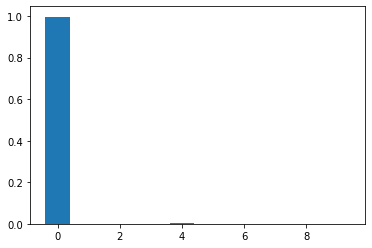

Adverserial image: 


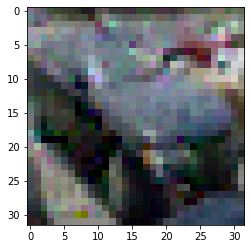

Actual image from which the adverserial image was produced: 


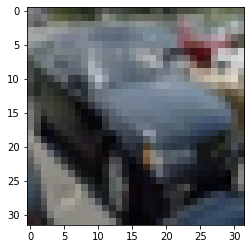

In [63]:
predict_2(advImage_0,classifier_2)

Network output: 
[[1.1290862e-04 4.0902039e-05 9.9863178e-01 1.6603174e-04 1.6443955e-04
  3.4774921e-04 8.6646774e-05 1.3218710e-04 2.2758770e-05 2.9444860e-04]]
Network prediction: 
2


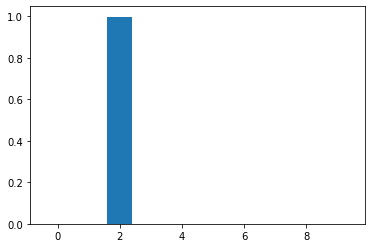

Adverserial image: 


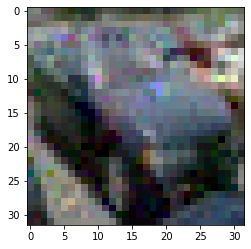

Actual image from which the adverserial image was produced: 


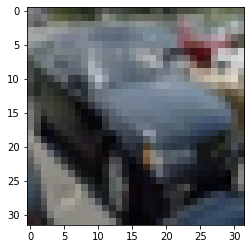

In [64]:
predict_2(advImage_2,classifier_2)

Network output: 
[[1.0695859e-04 1.2572701e-05 6.3423079e-04 9.9661875e-01 2.6484602e-04
  1.5909928e-03 2.6033871e-04 1.1233221e-04 2.5247718e-04 1.4652712e-04]]
Network prediction: 
3


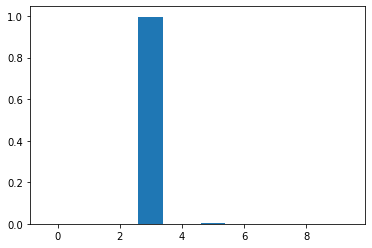

Adverserial image: 


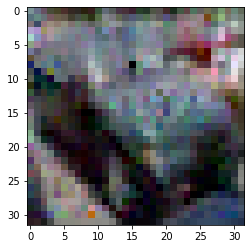

Actual image from which the adverserial image was produced: 


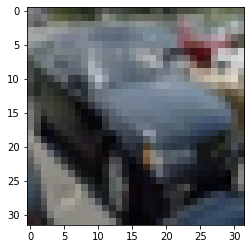

In [65]:
predict_2(advImage_3,classifier_2)

Network output: 
[[5.8119196e-05 7.0485603e-06 1.8996896e-05 4.8173224e-05 9.9965763e-01
  1.1990772e-05 2.1120559e-05 1.7011689e-04 4.9625082e-06 1.6824996e-06]]
Network prediction: 
4


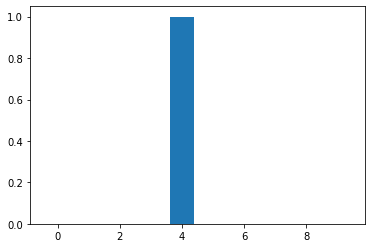

Adverserial image: 


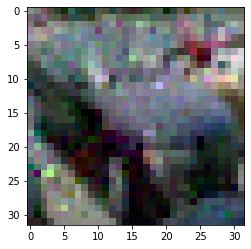

Actual image from which the adverserial image was produced: 


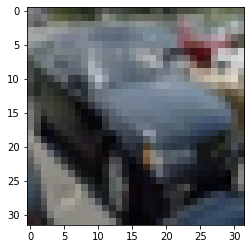

In [66]:
predict_2(advImage_4,classifier_2)

Network output: 
[[3.5550409e-05 1.3593766e-04 1.1063238e-03 1.2873781e-03 2.4821798e-04
  9.9312055e-01 1.5133014e-04 2.4131518e-03 1.3173475e-05 1.4885155e-03]]
Network prediction: 
5


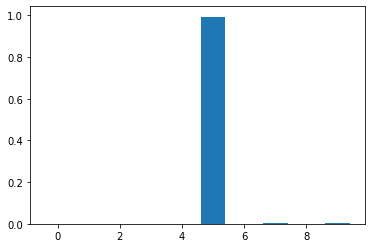

Adverserial image: 


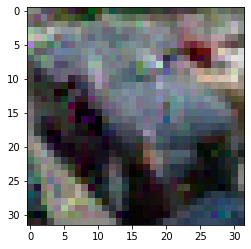

Actual image from which the adverserial image was produced: 


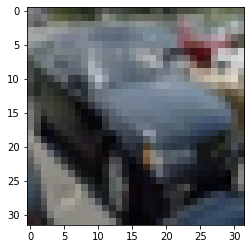

In [67]:
predict_2(advImage_5,classifier_2)

Network output: 
[[1.8446773e-06 9.8338478e-06 5.7060544e-05 1.5498081e-04 1.2928999e-05
  3.3145268e-05 9.9971575e-01 1.0342414e-06 3.9032493e-06 9.4752368e-06]]
Network prediction: 
6


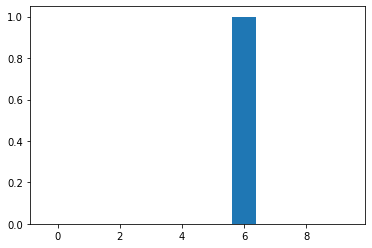

Adverserial image: 


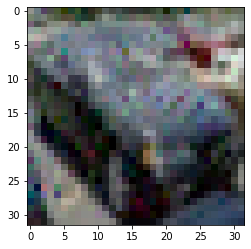

Actual image from which the adverserial image was produced: 


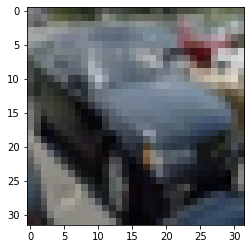

In [68]:
predict_2(advImage_6,classifier_2)

Network output: 
[[1.7929221e-04 8.5575339e-06 9.3160406e-06 3.1999789e-05 4.4039031e-04
  5.1032774e-05 6.9701196e-07 9.9926478e-01 4.8551459e-07 1.3436185e-05]]
Network prediction: 
7


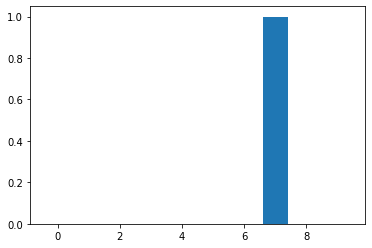

Adverserial image: 


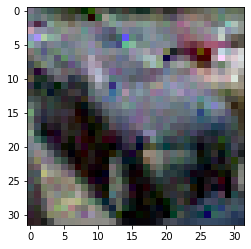

Actual image from which the adverserial image was produced: 


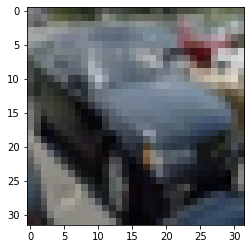

In [69]:
predict_2(advImage_7,classifier_2)

Network output: 
[[2.93239609e-05 1.11785805e-04 1.39438198e-04 1.91585699e-04
  1.22892874e-04 1.06170737e-05 4.98459813e-05 1.30514918e-05
  9.99236941e-01 9.45467618e-05]]
Network prediction: 
8


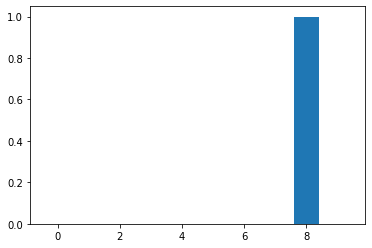

Adverserial image: 


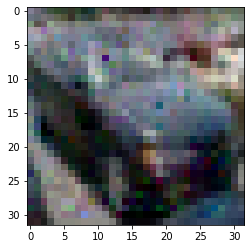

Actual image from which the adverserial image was produced: 


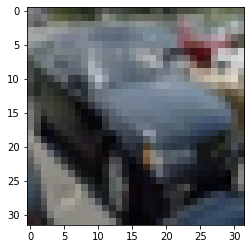

In [70]:
predict_2(advImage_8,classifier_2)

Network output: 
[[1.1742180e-05 3.4794313e-05 1.0875297e-05 8.6781620e-06 5.7594985e-07
  9.0206677e-06 2.5323022e-06 1.5059723e-05 6.3841667e-06 9.9990022e-01]]
Network prediction: 
9


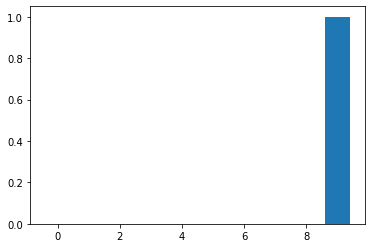

Adverserial image: 


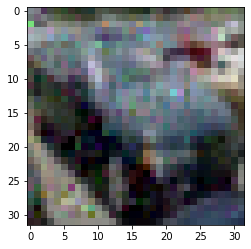

Actual image from which the adverserial image was produced: 


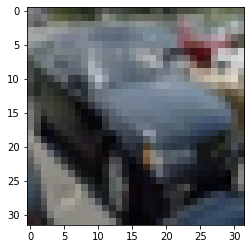

In [71]:
predict_2(advImage_9,classifier_2)

So as we can see above, although all adversarial examples look  similar to the original image, and despite the fact that classifier_2 managed to label the original image as no1 (automobile), it failed to classify all adversarial examples and labeled them as the labels that we decieved it to do so. We believe that a human will classify all the adversariial images as automobiles.

D)

Our proposal for the Model that will be robust to adversarial examples constructed in the above ways will be something quite simple. We will exploit all the 5 models created for each case (MNIST or CIFAR 10) and each time that my model will make the prediction will be randomly selected as one of those 5 models. In that case, the GAN will exploit only one out of the 5 models in order to create adversarial examples, but then when we will try to predict the adversarial example this will be done by using randomly one of the 5 models, diminishing the chance that this will make a wrong prediction

In [72]:

#Remember in the members list we saved models for the MNIST dataset and in the members_2 list we saved models
#for the CIFAR10 dataset

def Final_Model_Mnist():
    
    z=random.randint(1,5)
    return members[z-1]

def Final_Model_CIFAR10():
    
    z=random.randint(1,5)
    return members_2[z-1]


In [73]:
# So this function takes as input one digit (integer), in order to rename the layers of the GAN model created each time, so that 
# we avoid the unique layer name' issue. Also, each time a new GAN will be created , so the models that compose the GAN_3, will 
# be deleted every time the function is called, if they have been created again before (in that case, erase_ old _models should be
# 'yes as an input'

def GAN_3(digit,erase_old_models):
    global advModel_3
    global wholeModel_3
    if erase_old_models=='yes':
        del advModel_3
        del wholeModel_3
     
    final_model=Final_Model_Mnist() 
    final_model.trainable = False


    _3_Input = l.Input(shape=(1,),name='3_Input_'+str(digit))
    _3_hidden = l.Dense(256, activation='relu',name='3_hidden_1_'+str(digit))(_3_Input)
    _3_hidden = l.Dense(28*28, activation="sigmoid",name='3_hidden_2_'+str(digit))(_3_hidden)
    _3_output = l.Reshape((28,28), name='3_output_'+ str(digit))(_3_hidden)

    advModel_3 = m.Model(_3_Input, _3_output)
    advModel_3.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

    )




    wholeModel_3 = m.Model(_3_Input, final_model(_3_output))
    wholeModel_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.009),
    metrics=["accuracy"]
    )
    

Let's take a first glimpse of how our GAN looks. We will initiate firstly the GAN function

In [74]:
GAN_3(0,'no')
advModel.summary() #our generator model
wholeModel.summary() # the whole GAN model

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 hidden_1_8 (Dense)          (None, 256)               512       
                                                                 
 hidden_2_8 (Dense)          (None, 784)               201488    
                                                                 
 output_8 (Reshape)          (None, 28, 28)            0         
                                                                 
Total params: 202,000
Trainable params: 202,000
Non-trainable params: 0
_________________________________________________________________
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_8 (InputLayer)        [(Non

Now let's plot thw flow of these models

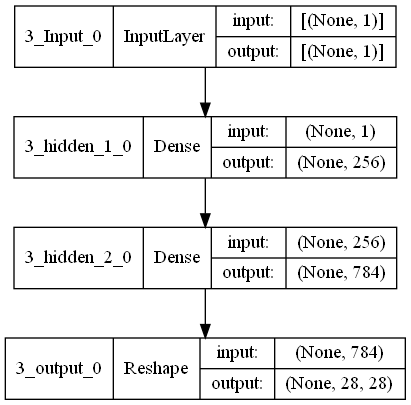

In [75]:
tf.keras.utils.plot_model(advModel_3, show_shapes=True)

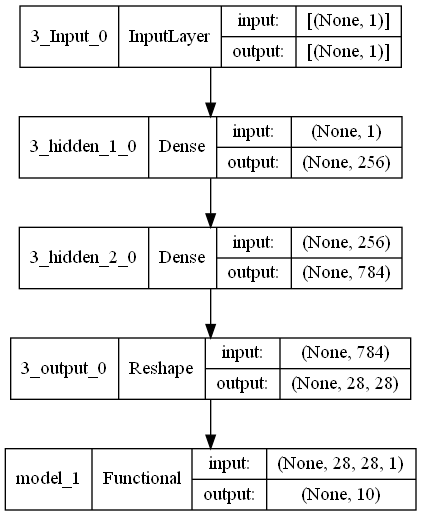

In [76]:
tf.keras.utils.plot_model(wholeModel_3, show_shapes=True)

Now we reload the MNIST dataset

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


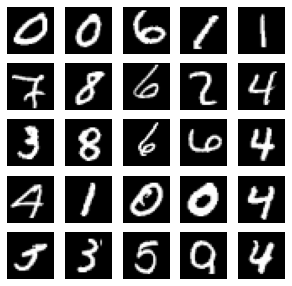

In [77]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [81]:
# So we will create five lists, for each chosen digit. For example predict_2 will be filled with 5 samples of x_test that 
#were inserted as input in classifier and predicted as output number 2

for num in range (0,9,2):
    #initilization of the 5 lists 
    globals()['predict_%s' %num]=[]


def sampling_pred(z,k):
    # a simple function that recieves as input a list (z) that contains random samples of x_test and a sample of x_test(k)
    #and if the list has less than 5 instances in it, it adds k in the list
    if len(z)==5:
        pass
    else:
        z.append(k)
    return z

for num in range(0,len(x_test),3):
    if predictions[num]==0:
        predict_0=sampling_pred(predict_0,x_test[num])
    elif predictions[num]==2:
        predict_2=sampling_pred(predict_2,x_test[num])
    elif predictions[num]==4:
        predict_4=sampling_pred(predict_4,x_test[num])
    elif predictions[num]==6:
        predict_6=sampling_pred(predict_6,x_test[num])
    elif predictions[num]==8:
        predict_8=sampling_pred(predict_8,x_test[num])

Let's start creating the adversial examples. We will choose as digits i the even numbers (0,2,4,6,8) and we will misclassify them as odd Js (1,3,5,7,9) respevtively, using one hot encoding. In order to do so, we will find ten predictions of our x_test dataset for each of the even numbers, in order to perform training. Firstly, for each training, we will show just one example to our Generator model and we will see how that will go. On the same time,  we will produce 5 images. For example, advImage_4, will be an array produced a 4 which will deceit our model in order to produce as a result something that possibly will confuse our model to produce 5 as its prediction

In [92]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=0
#GAN_3(check,'no') We have called the function in the above cells with the same inputs, so no need to call it again
for _ in tqdm(range(1000)):
    advModel_3.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel_3.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_3.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    
    

100%|██████████| 1000/1000 [00:46<00:00, 21.35it/s]


In [94]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=2
GAN_3(check,'yes')
for _ in tqdm(range(1000)):
    advModel_3.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel_3.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_3.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    
    

100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


In [95]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=4
GAN_3(check,'yes')
for _ in tqdm(range(1000)):
    advModel_3.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel_3.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_3.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    

100%|██████████| 1000/1000 [00:45<00:00, 21.84it/s]


In [96]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=6
GAN_3(check,'yes')
for _ in tqdm(range(1000)):
    advModel_3.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel_3.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_3.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    

100%|██████████| 1000/1000 [01:04<00:00, 15.43it/s]


In [97]:
#So we begin training. Firstly we misclassify 0s as 1s (one hot encoding of one: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] )
check=8
GAN_3(check,'yes')
for _ in tqdm(range(1000)):
    advModel_3.train_on_batch([np.array([check+1])], np.array([globals()['predict_%s' %check][0]]))
    wholeModel_3.train_on_batch([np.array([check+1])], to_categorical(check+1,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_3.predict([np.array([check+1])]).reshape(1, 28, 28, 1)
    

100%|██████████| 1000/1000 [01:03<00:00, 15.86it/s]


We will use the predict function that we have defined in the B) Part of the exercise. But now our predictor will be generated by the function Final_Model_Mnist() and it will be a random model from the members list

Network output: 
[[9.9297959e-01 2.4511324e-05 1.9485252e-04 7.7864324e-06 3.6895389e-04
  4.3160362e-05 6.2047909e-03 9.9150093e-06 1.3718820e-04 2.9236171e-05]]
Network prediction: 
0


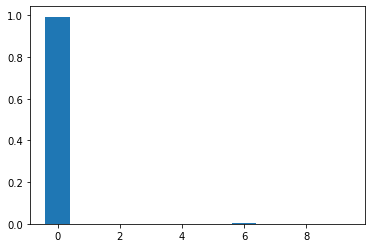

Adverserial image: 


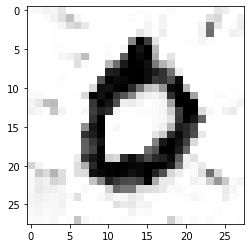

Actual image(s) from which the adverserial image was produced: 


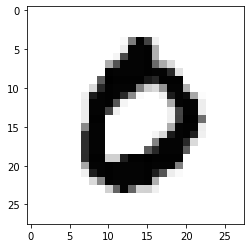

In [93]:
predict(advImage_0, Final_Model_Mnist(),0,1)

Network output: 
[[4.7143272e-05 1.7013524e-06 9.7676712e-01 1.9325441e-02 1.2204616e-06
  9.5621126e-06 7.2603007e-07 2.6618366e-04 3.5647938e-03 1.6148681e-05]]
Network prediction: 
2


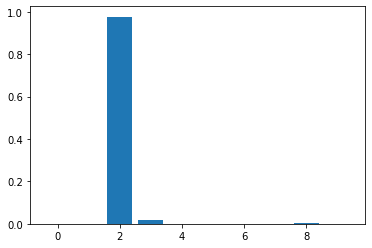

Adverserial image: 


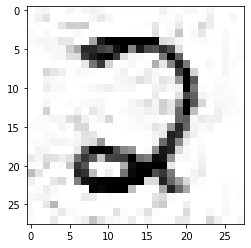

Actual image(s) from which the adverserial image was produced: 


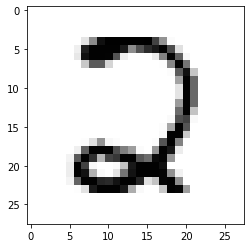

In [98]:
predict(advImage_2, Final_Model_Mnist(),2,1)

Network output: 
[[1.6602472e-06 2.5487319e-05 1.2898010e-04 9.1216600e-05 5.4432148e-01
  2.4264894e-04 3.6224126e-05 6.6860921e-05 4.2826429e-01 2.6821123e-02]]
Network prediction: 
4


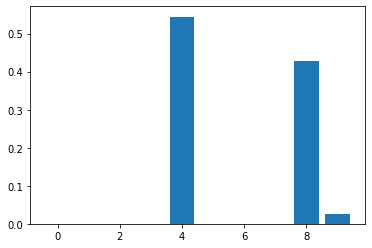

Adverserial image: 


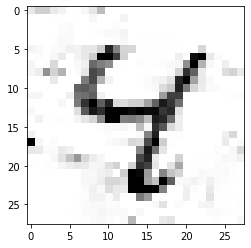

Actual image(s) from which the adverserial image was produced: 


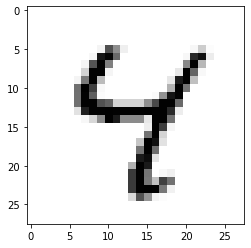

In [99]:
predict(advImage_4, Final_Model_Mnist(),4,1)

Network output: 
[[1.9001618e-05 1.4567508e-08 1.8902119e-05 3.1463558e-05 4.8603770e-06
  1.6862886e-02 9.8085231e-01 7.1452894e-07 2.2014196e-03 8.3216410e-06]]
Network prediction: 
6


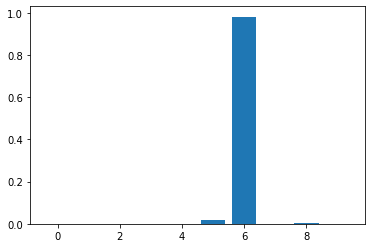

Adverserial image: 


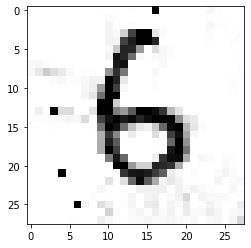

Actual image(s) from which the adverserial image was produced: 


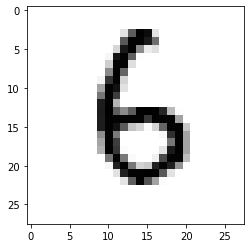

In [100]:
predict(advImage_6, Final_Model_Mnist(),6,1)

Network output: 
[[7.8396322e-03 4.3728658e-08 2.6584377e-03 1.3388024e-02 3.2190172e-05
  1.1876934e-02 1.4534454e-03 1.6566296e-06 9.5976365e-01 2.9859531e-03]]
Network prediction: 
8


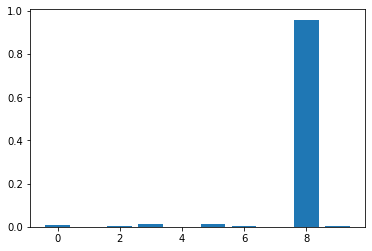

Adverserial image: 


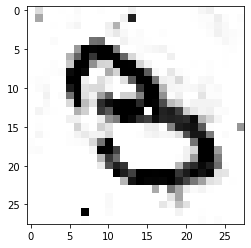

Actual image(s) from which the adverserial image was produced: 


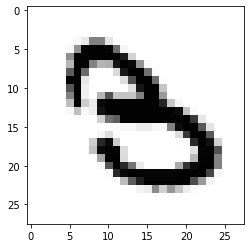

In [101]:
predict(advImage_8, Final_Model_Mnist(),8,1)

So as shown above, none of the 5 digit pictures was misclassified. We were expecting maybe an error since our GAN_3 was created by the one out of 5 identical models of the members list. Then, when we call the predict function there is a chance 1/5 that the Final_Model_Mnist() function will call the model that was used in order to creat the original GAN_3 Model. In the cases above we were lucky enough that in all cases when the Final_Model_Mnist function was called, none of the models exploited to created the adversial images was used. However, if we had constructed 100 identical models (instead of 5), then added them to the members list and  called them one at a time randomly through Final_Model_Mnist function, the chance that our GAN_3 will decieve the Final_Model would be much much smaller

Now let's proceed to the CIFAR10 dataset

In [102]:
# So this function takes as input one digit (integer), in order to rename the layers of the GAN model created each time, so that 
# we avoid the unique layer name' issue. Also, each time a new GAN will be created , so the models that compose the GAN, will 
# be deleted every time the function GAN_4 is called, if they have been created again before (in that case, erase_ old _models should be
# 'yes as an input'

def GAN_4(digit,erase_old_models):
    global advModel_4
    global wholeModel_4
    if erase_old_models=='yes':
        del advModel_4
        del wholeModel_4
     
    final_model_2=Final_Model_CIFAR10() 
    final_model_2.trainable = False


    _4_Input = l.Input(shape=(1,),name='4_Input_'+str(digit))
    _4_hidden = l.Dense(256, activation='relu',name='4_hidden_1_'+str(digit))(_4_Input)
    _4_hidden = l.Dense(32*32*3, activation="sigmoid",name='4_hidden_2_'+str(digit))(_4_hidden)
    _4_output = l.Reshape((32, 32,3),name='4_output_'+ str(digit))(_4_hidden)

    advModel_4 = m.Model(_4_Input, _4_output)
    advModel_4.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

    )




    wholeModel_4 = m.Model(_4_Input, final_model_2(_4_output))
    wholeModel_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.009),
    metrics=["accuracy"]
    )
    
    
    
    
    
    

Let's take a first glimpse of how our GAN looks. We will initiate firstly the GAN_4 function

In [103]:
GAN_4(0,'no')
advModel_4.summary() #our generator model
wholeModel_4.summary() # the whole GAN model

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 4_Input_0 (InputLayer)      [(None, 1)]               0         
                                                                 
 4_hidden_1_0 (Dense)        (None, 256)               512       
                                                                 
 4_hidden_2_0 (Dense)        (None, 3072)              789504    
                                                                 
 4_output_0 (Reshape)        (None, 32, 32, 3)         0         
                                                                 
Total params: 790,016
Trainable params: 790,016
Non-trainable params: 0
_________________________________________________________________
Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 4_Input_0 (InputLayer)      [(Non

Now let's plot thw flow of these models

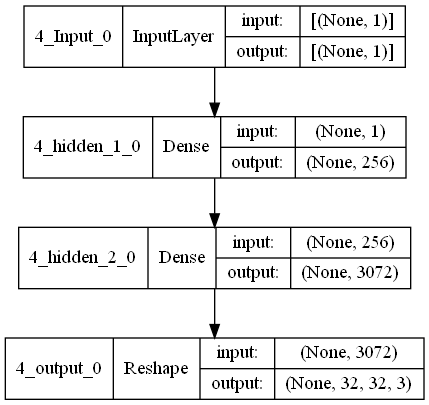

In [104]:
tf.keras.utils.plot_model(advModel_4, show_shapes=True)

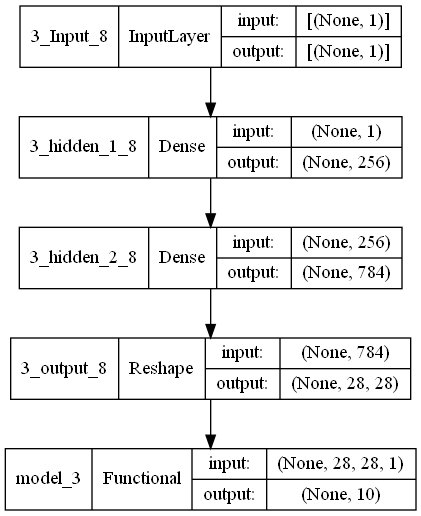

In [105]:
tf.keras.utils.plot_model(wholeModel_3, show_shapes=True)

Now we reload the MNIST dataset

In [106]:

ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [107]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [108]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [113]:
# So we will create ten lists, for each chosen digit. For example predict_9 will be filled with 5 samples of x_test that 
#were inserted as input in classifier and predicted as output number 9 (meaning that they were predicted as trucks for the
#case of the CIFAR 10 dataset)

for num in range (0,10):
    #initilization of the 10 lists 
    globals()['predict_%s' %num]=[]


def sampling_pred(z,k):
    # a simple function that recieves as input a list (z) that contains random samples of x_test and a sample of x_test(k)
    #and if the list has less than 5 instances in it, it adds k in the list
    if len(z)==5:
        pass
    else:
        z.append(k)
    return z

for num in range(0,len(x_test),2):
    label= predictions_2[num]
    globals()['predict_%s' %label]=sampling_pred(globals()['predict_%s' %label],x_test[num])

Let's start creating the adversial examples. We will now select a random sample  of the x_test of CIFAR10 dataset along with its prediciton (from predictions_2) and we will misclassify it to all other classes of the dataset

(For illustration purposes we will select the same sample of the dataset from part C) of the exercise that we used to create adversarial examples)

In [114]:
#remember that z was randomly selected in the above part C of the exercise
random_selection=x_test[z]
random_prediction=predictions_2[z]

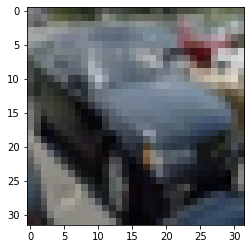

In [115]:
#Let's remember how it looked like
plt.imshow(random_selection)

In [116]:
random_prediction

1

So as shown above, we randomly picked an automobile, and our the random model that Final_Model_CIFAR10 function produced, has correctly predicted it(1 is the prediction for automobiles in CIFAR10 Dataset). So let's create some adversarial examples of that image (for the other classes of the CIFAR10). For example, advImage_4, will be an array produced of our automobile which will deceit our model in order to produce as a result something that possibly will confuse our model to produce 4 (deer for the case of the CIFAR 10 Dataset) as its prediction

In [117]:
#So we begin training. Firstly we misclassify 1 as 0 (one hot encoding of zero: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] )
check=0
#GAN_4(check,'no') We have called the function in the above cells with the same inputs, so no need to call it again
for _ in tqdm(range(1000)):
    advModel_4.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_4.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_4.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


In [118]:
#Then we misclassify 1 as 4
check=4
GAN_4(check,'yes')
for _ in tqdm(range(1000)):
    advModel_4.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_4.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_4.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:04<00:00, 15.49it/s]


In [119]:
#Then we misclassify 1 as 9
check=9
GAN_4(check,'yes')
for _ in tqdm(range(1000)):
    advModel_4.train_on_batch([np.array([1])], np.array([random_selection]))
    wholeModel_4.train_on_batch([np.array([1])], to_categorical(check,10).reshape(1,10))
globals()['advImage_%s' %check]=advModel_4.predict([np.array([1])]).reshape(1, 32, 32, 3)

100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


So we created 3 adversarial images. Let's see how are new predictor produced by Final_Model_CIFAR10 function will perform this time. In order to demonstrate our results, we will use the predict_2 function that we created in part C) of the exercise

Network output: 
[[0.06097664 0.37828648 0.01451554 0.00363859 0.00190507 0.00108051
  0.23269871 0.00096708 0.00746308 0.2984683 ]]
Network prediction: 
1


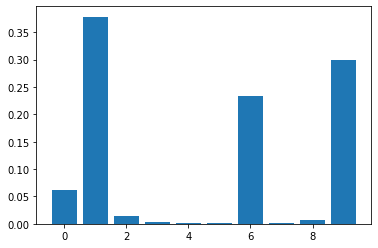

Adverserial image: 


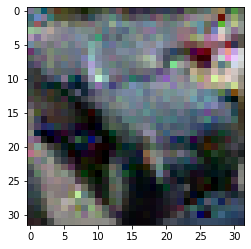

Actual image from which the adverserial image was produced: 


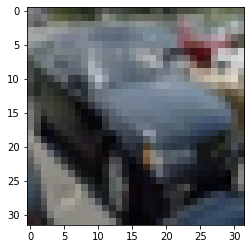

In [122]:
predict_2(advImage_0,Final_Model_CIFAR10())

Network output: 
[[1.0290287e-03 9.0651949e-05 5.1460881e-04 2.9235441e-04 9.9401361e-01
  6.1762214e-05 2.8463014e-04 3.1066481e-03 1.0942911e-04 4.9724430e-04]]
Network prediction: 
4


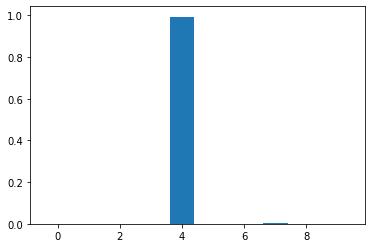

Adverserial image: 


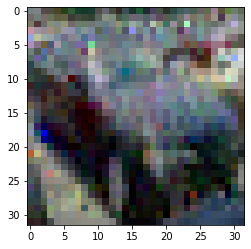

Actual image from which the adverserial image was produced: 


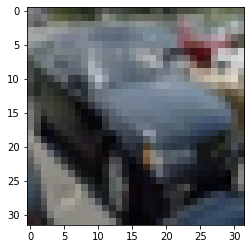

In [126]:
predict_2(advImage_4,Final_Model_CIFAR10())

Network output: 
[[8.8484166e-04 3.1519860e-02 1.5789133e-03 1.0265977e-03 1.9928455e-04
  4.3955873e-04 7.3271729e-02 1.2165546e-04 1.3305550e-03 8.8962698e-01]]
Network prediction: 
9


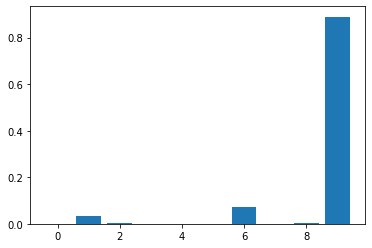

Adverserial image: 


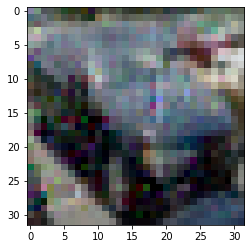

Actual image from which the adverserial image was produced: 


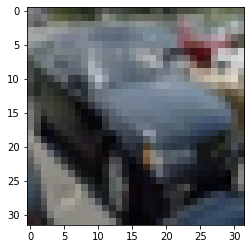

In [124]:
predict_2(advImage_9,Final_Model_CIFAR10())

So as we see above, our model produced by the function Final_Model_CIFAR10 managed to classify correctly all 3 adversarial examples as automobiles